In [16]:
from scipy import misc, sparse
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from skimage import io
import warnings
import json
warnings.filterwarnings('ignore')
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry.point import Point
import pickle
from itertools import compress
from ast import literal_eval

from IPython.display import display, HTML


colorsHex = [
    '#FFFFFF',
    '#E4E4E4',
    '#888888',
    '#222222',
    '#FFA7D1',
    '#E50000',
    '#E59500',
    '#A06A42',
    '#E5D900',
    '#94E044',
    '#02BE01',
    '#00E5F0',
    '#0083C7',
    '#0000EA',
    '#E04AFF',
    '#820080'
]


def HexToRGB(hexStr):
    return tuple(int(hexStr.strip('#')[i:i+2], 16) for i in (0, 2 ,4))

def RGBToHex(value):
    return ('#%02x%02x%02x' % (value[0], value[1], value[2])).upper()

def idxToHex(idx):
    return colorsHex[idx]

def idxToRGB(idx):
    return HexToRGB(colorsHex[idx])

def HexToIdx(hexStr):
    return colorsHex.index(hexStr)

def RGBToIdx(rgb):
    return HexToIdx(RGBToHex(rgb))

def showImage(image, size=(12,12), ax=None):
    if not ax:
        _, ax = plt.subplots(1,1, figsize=size)
    ax.imshow(image.transpose((1,0,2)), interpolation='nearest')
    ax.grid(False)
    
def canvas_idx_to_rgb(canvas):
    canvas_final = np.ones((canvas.shape[0],canvas.shape[1], 3), dtype=np.int64)*255
    for x in range(canvas.shape[0]):
        for y in range(canvas.shape[1]):
            canvas_final[x,y] = idxToRGB(canvas[x,y])
    return canvas_final

We first define the minimum area of a shape in order to be considered, the idea is that conflict will be more visible on big areas (and involve more people)

In general, I packed the coordinate to be more memory efficient, that is the coordinate now range from 0 to `1'000*1'000+1'000 = 1'001'000`, so `packed_coord = x*1000+y`, in order to unpack `x=packed_coord//1000` and `y=packed_coord%1000`

There are several data structures, the one of interest are
- `atlas_with_poly` that contains all the shape contained in the atlas with a polygon and a size of at least the threshold, it contains pretty much everything, including the name, subreddit, etc.
- `polys_packed` that contains a list of coordinates in the packed format for each polyhon
- `dataset` which contains the point, filtered to only keep those present in the polygons described above, with the timestamp normalized to the second (and starting from 0), the timestamp in minute and hour. It also contains a "correct" boolean, which states if the pixel placed is correct regarding the corrected version of the canvas.

In [11]:
area_threshold = 1000

dataset = pd.read_csv("dataset/tile_placements.csv")
dataset = dataset[(dataset['x_coordinate'] < 1000) & (dataset['y_coordinate'] < 1000)]

dataset['coordinates_packed'] = dataset['x_coordinate'] * 1000 + dataset['y_coordinate']

dataset.drop(columns=['x_coordinate', 'y_coordinate'], inplace=True)
# dataset['coordinates'] = list(zip(dataset['x_coordinate'], dataset['y_coordinate']))

canvas_corr = np.load('canvas_corr_idx.npy')
canvas_final = np.load('canvas_final_idx.npy')

with open('atlas/atlas_with_mask.pickle', 'rb') as infile:
    atlas = pickle.load(infile)

atlas_with_poly = [poly for poly in atlas if 'poly_mask' in poly and len(poly['poly_mask'][0]) > area_threshold]

id2Idx = {shape['id']: idx for idx, shape in enumerate(atlas_with_poly)}
idx2Id = {v: k for k,v in id2Idx.items()}

polys = [np.array(shape['poly_mask']) for shape in atlas_with_poly]

polys_packed = [poly[0]*1000+poly[1] for poly in polys]

valid_coords = list(set([tup[0]*1000+tup[1] for poly in polys for tup in list(map(tuple, poly.T))]))

dataset =  dataset[dataset['coordinates_packed'].isin(valid_coords)]

dataset['user'] = dataset['user'].astype('category')

starting_ts = int(dataset['ts'].min())
dataset['ts'] = (dataset['ts']-starting_ts)//1000

color_correctness = []
for ts, _, color, coords in dataset.values:
    x, y = coords//1000, coords%1000
    color_correctness.append(canvas_corr[x,y] == color)
color_correctness = np.array(color_correctness)
dataset['correct'] = color_correctness
dataset['ts_hour'] = dataset['ts']//3600
dataset['ts_minute'] = dataset['ts']//60

Helper function to plot the ratio of good pixel by second/minute/hour. Because of the construction of the "correct" field, the ratio is equivalent to the mean of correct pixels in a particular time.

In [12]:
def plot_conflict_ration(filtering=np.array([True] * len(dataset)), title=""):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    dataset[filtering].groupby('ts')['correct'].mean().plot(ax=axes[0][0])
    dataset[filtering].groupby('ts_minute')['correct'].mean().plot(ax=axes[0][1])
    dataset[filtering].groupby('ts_hour')['correct'].mean().plot(ax=axes[1][0])
    axes[-1, -1].axis('off')

    plt.suptitle(title + ' conflict ratio', fontsize=16)
    plt.subplots_adjust(top=10)
    fig.text(0.5, -0.001, 'Time', ha='center', size=14)
    fig.text(-0.01, 0.5, 'Conflict ratio', va='center', rotation='vertical', size=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

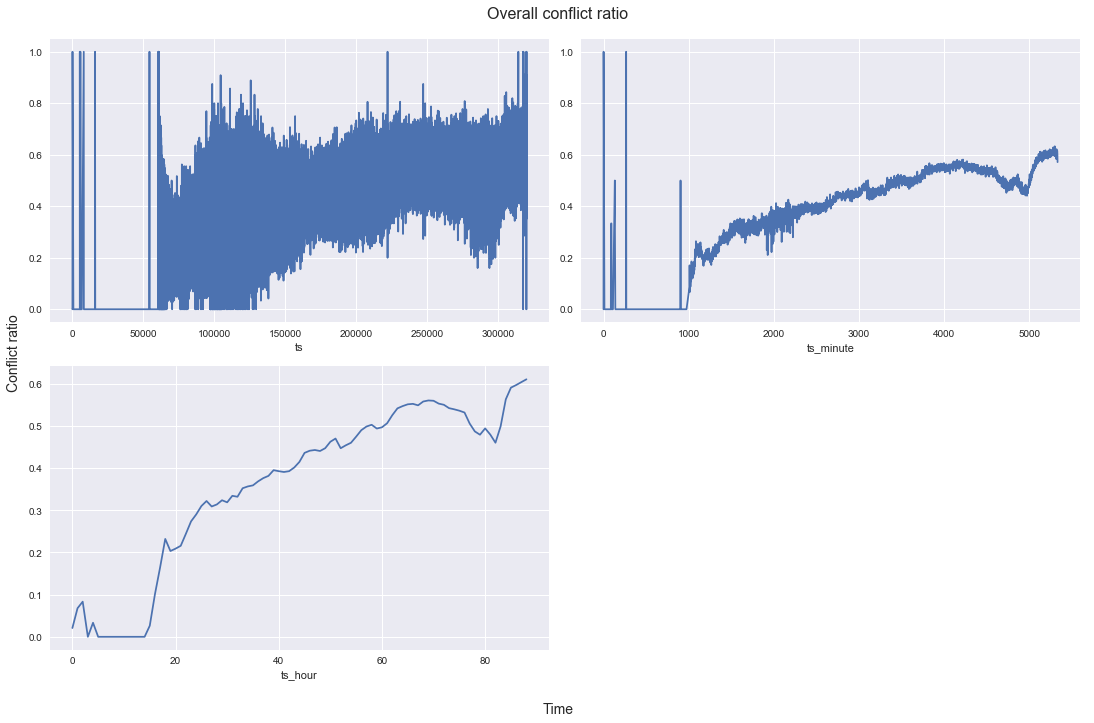

In [13]:
plot_conflict_ration(title='Overall')

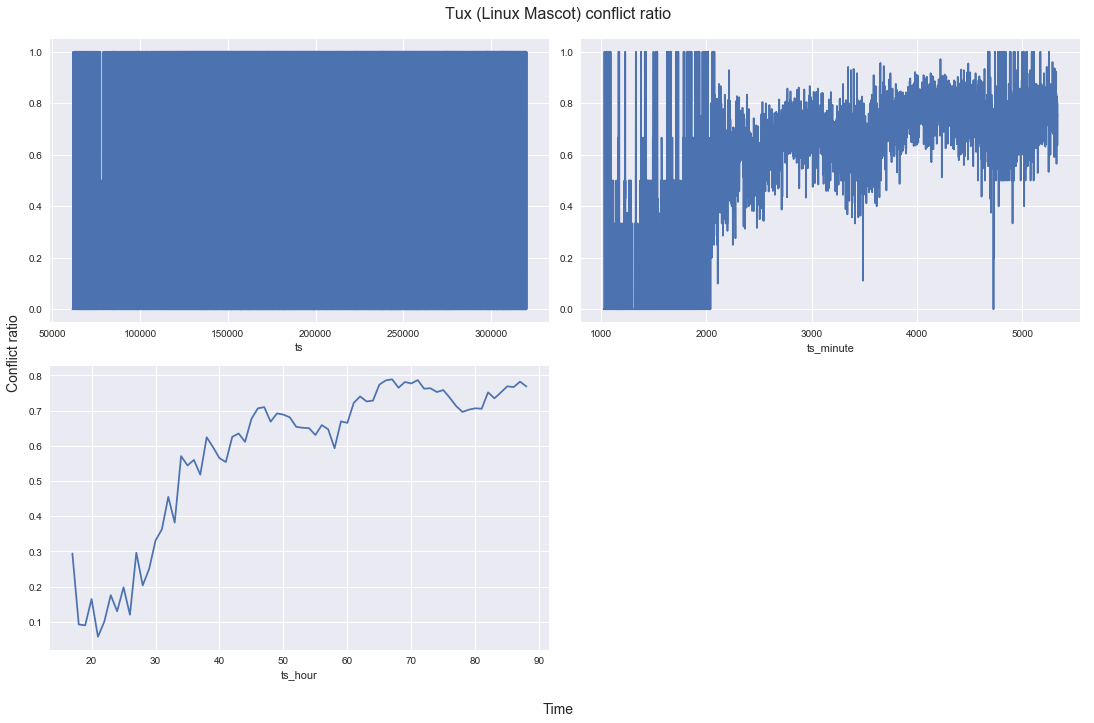

In [14]:
plot_conflict_ration(dataset['coordinates_packed'].isin(polys_packed[0]), title=atlas_with_poly[0]['name'])

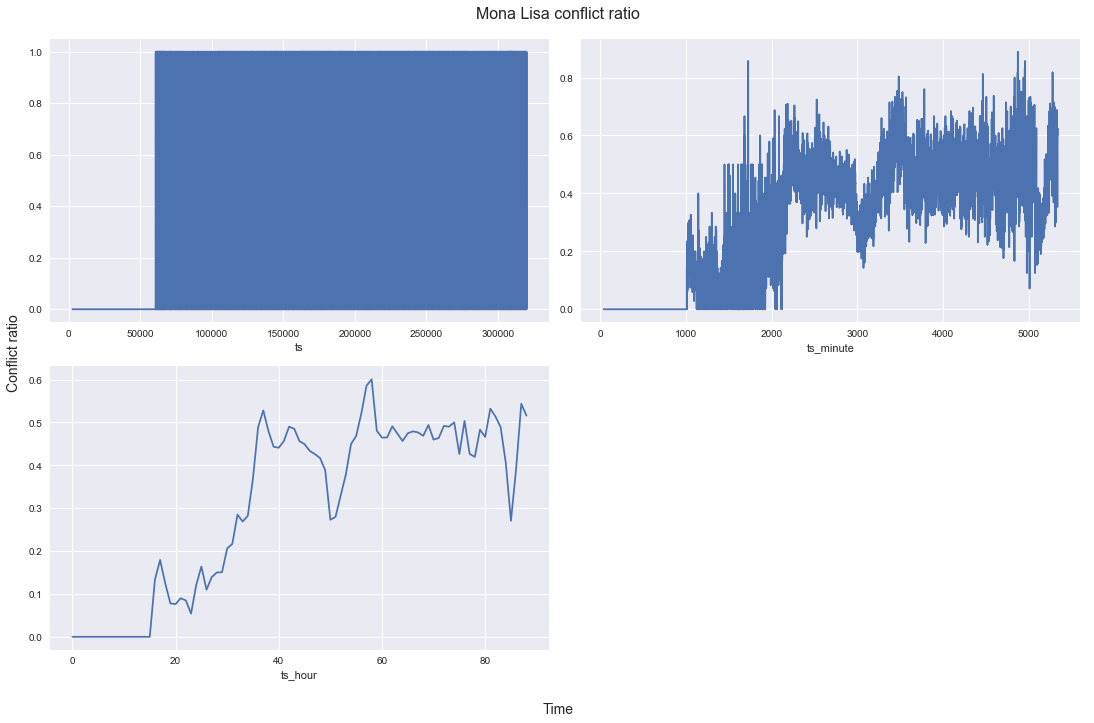

In [15]:
plot_conflict_ration(dataset['coordinates_packed'].isin(polys_packed[1]), title=atlas_with_poly[1]['name'])

## User subreddits

We first create a dataframe that contains the subreddits to which a coordinate belongs

In [19]:
packedCoord2Subreddits = {}
for idx, poly in enumerate(polys_packed):
    sub_names = [x.strip().lower() for x in atlas_with_poly[idx]['subreddit'].split(',')]
    for i in range(len(atlas_with_poly[idx]['poly_mask'][0])):
        packed_coord = atlas_with_poly[idx]['poly_mask'][0][i]*1000+atlas_with_poly[idx]['poly_mask'][1][i]
        if not packed_coord in packedCoord2Subreddits:
            packedCoord2Subreddits[packed_coord] = []
        packedCoord2Subreddits[packed_coord].extend(sub_names)
packed_coord_subreddit_df = pd.DataFrame([[packed_coord, sub] for packed_coord, subs in packedCoord2Subreddits.items() for sub in subs], columns=['coordinates_packed', 'subreddit']).set_index('coordinates_packed')

We then map each action to a subreddit by joining the coordinate per subreddit.

Note that it will have the effect of duplicating the entry if a pixel belongs to several subreddits.

In [20]:
dataset_flat = dataset.set_index("coordinates_packed").join(packed_coord_subreddit_df).reset_index()
dataset_flat['user'] = dataset_flat['user'].astype('category')
dataset_flat['subreddit'] = dataset_flat['subreddit'].astype('category')
dataset_flat['incorrect'] = 1-dataset_flat['correct']
dataset_flat['direction'] = dataset_flat['correct']*2-1

dataset_flat.head()

,coordinates_packed,ts,user,color,correct,ts_hour,ts_minute,subreddit,incorrect,direction
0,38,248619,NbHA5m8Sr15Dhcyy+o+YIOfGI0Y=,3,True,69,4143,/r/purplepixels,0,1
1,38,201675,FJfrFcqvp4AbOzoeIzOwKIXSADY=,15,False,56,3361,/r/purplepixels,1,-1
2,38,292720,63UJT/arm5DObCrz7skxy5l/2HE=,3,True,81,4878,/r/purplepixels,0,1
3,38,237387,pKn9bV9XLpOpTl7/dI372HoCyxU=,0,False,65,3956,/r/purplepixels,1,-1
4,38,225479,X0jeGT/cxC7X8dmeisclEDChuaE=,8,False,62,3757,/r/purplepixels,1,-1


OR

In [11]:
dataset_flat = pd.read_csv('dataset/tile_placements_area_1000_flat.csv', index_col=0)
dataset_flat['user'] = dataset_flat['user'].astype('category')
dataset_flat['subreddit'] = dataset_flat['subreddit'].astype('category')
dataset_flat['incorrect'] = 1-dataset_flat['correct']
dataset_flat['direction'] = dataset_flat['correct']*2-1

dataset_flat.head()

### Analysis

We first only consider positive and negative action, without considering action that negated another one. E.g. a user place a good pixel for a subreddit, but then placed a bad pixel for this community, then maybe negate the whole contribution (sum of action = 0), but this approach does not takes that into account.

In [21]:
threshold = 10

Showing stats for big positive and negative action (less chance of it being spam)

In [22]:
user_subreddit_positive = dataset_flat.groupby(['user', 'subreddit'])['correct'].sum()
big_positive = user_subreddit_positive[(user_subreddit_positive >= threshold)]

user_subreddit_positive.describe(percentiles=[.25, .5, .75, .80, .90, .99, .999])

count    4.693011e+06
mean     1.807867e+00
std      7.187640e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
80%      1.000000e+00
90%      3.000000e+00
99%      3.000000e+01
99.9%    9.400000e+01
max      6.130000e+02
Name: correct, dtype: float64

In [23]:
user_subreddit_negative = dataset_flat.groupby(['user', 'subreddit'])['incorrect'].sum()
big_negative = user_subreddit_negative[(user_subreddit_negative >= threshold)]

user_subreddit_negative.describe(percentiles=[.25, .5, .75, .80, .90, .99, .999])

count    4.693011e+06
mean     2.083666e+00
std      5.906543e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
80%      2.000000e+00
90%      4.000000e+00
99%      2.400000e+01
99.9%    7.300000e+01
max      4.740000e+02
Name: incorrect, dtype: float64

Among the significant action, we make a ranking of subreddit by number of user contributing significantly (positively and negatively)

In [24]:
positive_users = big_positive.index.get_level_values(0)
negative_users = big_negative.index.get_level_values(0)
mixed_users = positive_users.intersection(negative_users)

In [25]:
max_display = 20
with pd.option_context('display.max_rows', max_display):
    display(big_positive.loc[list(set(positive_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
r/ainbowroad,9330
/r/americanflaginplace,9317
/r/osugame/,5392
/r/placenl,4523
/r/canada,4505
/r/sweden,4503
/r/de,4147
/r/placede,4147
/r/thebluecorner,3802


In [26]:
with pd.option_context('display.max_rows', max_display):
    display(big_negative.loc[list(set(negative_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
r/ainbowroad,12408
/r/osugame/,7036
/r/placenl,6825
/r/americanflaginplace,5289
/r/thegreatblackhole,4362
/r/placestart,3609
/r/tfls,3608
,3453
/r/canada,3331


### Overall

Now taking into account the sum of action of each user.

In [27]:
min_pixels = 10

In [28]:
user_subreddit_overall = dataset_flat.groupby(['user', 'subreddit'])['direction'].sum()
user_subreddit_overall.describe(percentiles=[.25, .5, .75, .80, .90, .99, .999])

count    4.693011e+06
mean    -2.757991e-01
std      7.533115e+00
min     -4.730000e+02
25%     -1.000000e+00
50%     -1.000000e+00
75%      1.000000e+00
80%      1.000000e+00
90%      2.000000e+00
99%      2.100000e+01
99.9%    7.300000e+01
max      5.470000e+02
Name: direction, dtype: float64

In [29]:
big_overall = user_subreddit_overall[(user_subreddit_overall >= min_pixels) | (user_subreddit_overall <= -min_pixels)]
big_overall_positive = user_subreddit_overall[(user_subreddit_overall >= min_pixels)]
big_overall_negative = user_subreddit_overall[(user_subreddit_overall <= -min_pixels)]

positive_overall_users = big_overall_positive.index.get_level_values(0)
negative_overall_users = big_overall_negative.index.get_level_values(0)

In [30]:
max_display = 20
with pd.option_context('display.max_rows', max_display):
    display(big_overall_positive.loc[list(set(positive_overall_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
/r/americanflaginplace,8216
r/ainbowroad,4140
/r/osugame/,3899
/r/sweden,3753
/r/thebluecorner,3424
/r/orderofthebluecorner,3424
/r/canada,3051
/r/prequelmemes,2757
/r/placenl,2648


In [31]:
with pd.option_context('display.max_rows', max_display):
    display(big_overall_negative.loc[list(set(negative_overall_users.astype('str').values))].reset_index()
         .groupby('subreddit').size().sort_values(ascending=False).to_frame().head(max_display))

,0
subreddit,
r/ainbowroad,6265
/r/osugame/,4899
/r/americanflaginplace,4103
/r/placenl,3820
/r/thegreatblackhole,2682
,2539
/r/thebluecorner,2539
/r/orderofthebluecorner,2539
/r/placestart,2471


We now extract "mixed" users, i.e. users having done big positive AND negative actions, we then figure out their "camps" and can thus analyze the conflicts

In [32]:
mixed_overall_users = positive_overall_users.intersection(negative_overall_users)

mixed_users_camps = big_overall.loc[list(set(mixed_overall_users.astype('str').values))].reset_index(level=1)
positive_actions = mixed_users_camps[mixed_users_camps['direction'] > 0]['subreddit']
negative_actions = mixed_users_camps[mixed_users_camps['direction'] < 0]['subreddit']
df_camps = positive_actions.to_frame().rename(columns={'subreddit': 'positive_subreddit'})\
    .join(negative_actions.to_frame().rename(columns={'subreddit': 'negative_subreddit'}))

In [37]:
with pd.option_context('display.max_rows', 100):
    display(df_camps.groupby(['positive_subreddit', 'negative_subreddit'])
                .size().reset_index().sort_values(by=0, ascending=False).head(1000))

,positive_subreddit,negative_subreddit,0
6421,/r/sweden,r/denmark,382
572,/r/americanflaginplace,r/ainbowroad,247
4413,/r/osugame/,/r/placestart,171
4433,/r/osugame/,/r/stlouis/,154
548,/r/americanflaginplace,/r/tfls,146
4434,/r/osugame/,/r/stlouisblues,136
499,/r/americanflaginplace,/r/norge,136
1569,/r/de,/r/europe,127
4721,/r/placede,/r/europe,127
519,/r/americanflaginplace,/r/purplepixels,117


Since some communities attract all the conflict, we filter them out to better see smaller conflicts.

We remove the empty string community, which correspond to shape with no subreddit.

In [42]:
def create_filter(strings):
    filtering = df_camps.positive_subreddit.str.contains("")
    for string in strings:
        filtering = (filtering &
                     ~df_camps.positive_subreddit.str.contains(string) &
                     ~df_camps.negative_subreddit.str.contains(string))
    return filtering

filter_communities = create_filter([" "])

In [48]:
with pd.option_context('display.max_rows', 1000):
    display(df_camps[(df_camps.positive_subreddit.str.len() > 0) & (df_camps.negative_subreddit.str.len() > 0)].groupby(['positive_subreddit', 'negative_subreddit'])
                .size().reset_index().sort_values(by=0, ascending=False).head(1000))

,positive_subreddit,negative_subreddit,0
6231,/r/sweden,r/denmark,382
465,/r/americanflaginplace,r/ainbowroad,247
4245,/r/osugame/,/r/placestart,171
4265,/r/osugame/,/r/stlouis/,154
441,/r/americanflaginplace,/r/tfls,146
392,/r/americanflaginplace,/r/norge,136
4266,/r/osugame/,/r/stlouisblues,136
4550,/r/placede,/r/europe,127
1446,/r/de,/r/europe,127
412,/r/americanflaginplace,/r/purplepixels,117
